# Wine Classification

Some quick tests and classification performed on well known [wine dataset from kaggle](https://www.kaggle.com/datasets/sh6147782/winequalityred)

In [2]:
#Update pandas
!pip install --upgrade pandas

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
#Sagemaker setup
import sagemaker
bucket=sagemaker.Session().default_bucket()
prefix = 'sagemaker/Xgboost-wine'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [4]:
#Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
import sys
import math
import csv
import os
import sagemaker 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
%matplotlib inline

In [5]:
#import data into dataframe
data = pd.read_csv('./winequality-red.csv')

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1591,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1592,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1593,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1594,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Data exploration

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000
mean,8.314160,0.527954,0.270276,2.535558,0.087120,15.858396,46.382206,0.996744,3.311917,0.656385,10.421147,5.637218
std,1.732203,0.179176,0.193894,1.405515,0.045251,10.460554,32.839138,0.001888,0.153346,0.163057,1.060371,0.807080
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996745,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997833,3.400000,0.730000,11.100000,6.000000
max,15.600000,1.580000,0.790000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.000000,8.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1596 non-null   float64
 1   volatile acidity      1596 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1596 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1596 non-null   float64
 6   total sulfur dioxide  1596 non-null   float64
 7   density               1596 non-null   float64
 8   pH                    1596 non-null   float64
 9   sulphates             1596 non-null   float64
 10  alcohol               1596 non-null   float64
 11  quality               1596 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 149.8 KB


None

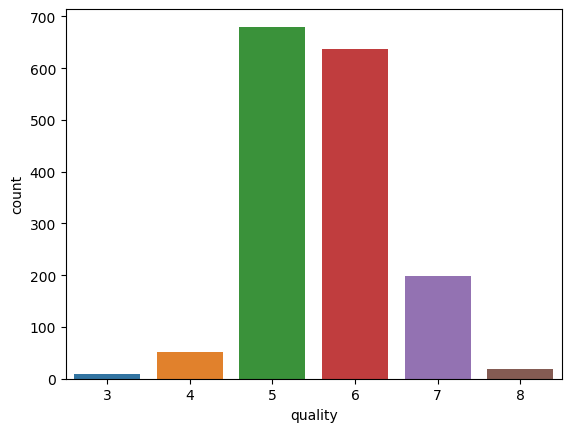

In [6]:
display(data.describe())
display(data.info())
sns.countplot(data['quality'])

Quick observations:
* No NaN values
* Most examples fall into medium quality category

### Spliting wine into low and high quality (relabeling)

[Text(0.5, 1.0, 'Count after re-labeling')]

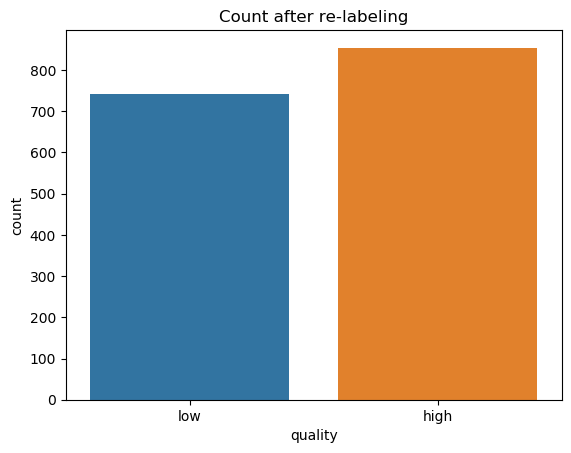

In [7]:
bins = (1, 5.5, 8)
levels = ['low', 'high']

data['quality'] = pd.cut(data['quality'], bins = bins, labels = levels)
sns.countplot(data['quality']).set(title='Count after re-labeling')

### Data extraction, labeling

In [8]:
##ncoding quality labesls 
encoder = LabelEncoder().fit(data['quality'])
data['quality'] = encoder.transform(data['quality'])


In [9]:
#Scaling data
scaler = MinMaxScaler()
x = data.drop(['quality'], axis=1)
data_scaled = scaler.fit_transform(x.to_numpy())
x_scaled = pd.DataFrame(data_scaled, columns = x.columns)
data_scaled = pd.concat([x_scaled, data['quality']], axis=1)

In [10]:
#Data split
train_data, validation_data, test_data = np.split(data_scaled.sample(frac=1, random_state=1213), [int(0.7 * len(data)), int(0.9 * len(data))])

In [11]:
pd.concat([train_data['quality'], train_data.drop(['quality'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['quality'], validation_data.drop(['quality'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### Training and Tuning

In [12]:
# Session, Container and XGB instaance
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

In [16]:
# Hyperparameter tuning
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(0, 10),
                            'num_round': IntegerParameter(1, 1000)}

objective_metric_name = 'validation:auc'

In [17]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=8,
                            max_parallel_jobs=2)

In [18]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................!


In [19]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [20]:
tuner.best_training_job()

'xgboost-230306-1100-004-0cbfa0ac'

In [21]:
#  Deploy the best trained or user specified model to an Amazon SageMaker endpoint
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


2023-03-06 11:06:18 Starting - Found matching resource for reuse
2023-03-06 11:06:18 Downloading - Downloading input data
2023-03-06 11:06:18 Training - Training image download completed. Training in progress.
2023-03-06 11:06:18 Uploading - Uploading generated training model
2023-03-06 11:06:18 Completed - Resource reused by training job: xgboost-230306-1100-007-3c276314
------!

### Evaluation

In [22]:
# Predict function from tutorial
def predict(data, predictor, rows=500 ):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [23]:
# Create a serializer
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

# Predict
predictions = predict(test_data.drop(['quality'], axis=1).to_numpy(),tuner_predictor)

In [24]:
print(classification_report(test_data['quality'], np.round(predictions), target_names=['low', 'high']))

pd.crosstab(index=test_data['quality'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


              precision    recall  f1-score   support

         low       0.81      0.80      0.80        89
        high       0.75      0.76      0.76        71

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160



predictions,0.0,1.0
actuals,,
0,71,18
1,17,54


## Cleaning Up

In [28]:
tuner_predictor.delete_endpoint(delete_endpoint_config=True)